In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crimes-chicago-small-2003-present/Crimes_short.csv
/kaggle/input/weather/weather_tps_25.csv


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df=pd.read_csv("/kaggle/input/crimes-chicago-small-2003-present/Crimes_short.csv")

In [7]:
# make copy of df, restrict to domestic / non-domestic / all / Years after 2002:
cdf=df.copy()
#cdf=cdf[cdf["Domestic"]==False]
cdf=cdf[cdf.Year > 2002]

In [8]:
cdf

,Unnamed: 0,ID,Date,Primary Type,Domestic,Community Area,Year
0,0,11037294,03/18/2015 12:00:00 PM,DECEPTIVE PRACTICE,False,32.0,2015
1,1,11646293,12/20/2018 03:00:00 PM,DECEPTIVE PRACTICE,False,19.0,2018
2,2,11645836,05/01/2016 12:25:00 AM,DECEPTIVE PRACTICE,False,63.0,2016
3,3,11645959,12/20/2018 04:00:00 PM,OTHER OFFENSE,False,14.0,2018
4,4,11645601,06/01/2014 12:01:00 AM,DECEPTIVE PRACTICE,False,71.0,2014
...,...,...,...,...,...,...,...
7162142,8134887,12131776,08/10/2020 08:30:00 PM,BURGLARY,False,66.0,2020
7162143,8134888,12082414,06/18/2020 09:00:00 PM,THEFT,False,49.0,2020
7162144,8134889,12118237,07/27/2020 03:02:00 PM,BATTERY,True,27.0,2020
7162145,8134890,12142591,08/14/2020 03:00:00 PM,MOTOR VEHICLE THEFT,False,2.0,2020


In [9]:
df_25=df[df["Community Area"]==25].drop(columns="Community Area")

In [10]:
df_25["date"]=pd.to_datetime(df_25.Date)

In [11]:
df_25["day"]=df_25['date'].dt.to_period('D')

In [12]:
ca25daily_df=df_25.groupby("day").count().rename(columns={"ID" : "crime_count" })[["crime_count"]]

<Axes: xlabel='day'>

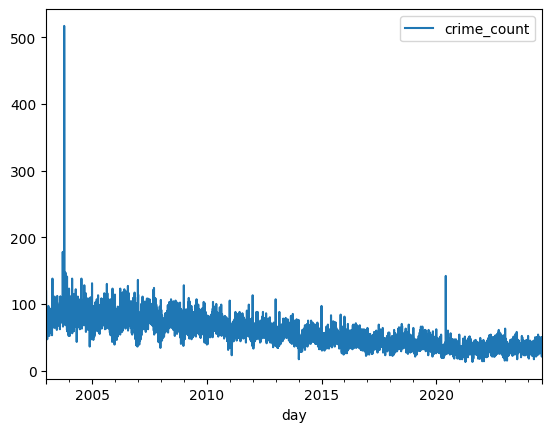

In [13]:
ca25daily_df.plot()

In [14]:
ca25daily_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 7894 entries, 2003-01-01 to 2024-08-11
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   crime_count  7894 non-null   int64
dtypes: int64(1)
memory usage: 123.3 KB


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
# PREPROCESS

crime_count_list = list(ca25daily_df["crime_count"])

sequence_length = 365  # number of days to consider for predicting the next day

# create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# train test val split

train_size = int(len(X) * 0.9)  # 90% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

In [17]:
# SCALING

scaler=MinMaxScaler()

scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [18]:
# NN Architecture

model = Sequential()

model.add(layers.GRU(units=32, activation='relu', input_shape=(365, 1), return_sequences=True))
model.add(layers.GRU(units=32, activation='relu', return_sequences=True))
model.add(layers.GRU(units=16, activation='relu', return_sequences=True))
model.add(layers.GRU(units=8, activation='relu'))

model.add(layers.Dense(8, activation="relu")) 
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 365, 32)        │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 365, 32)        │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 365, 16)        │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,873 (50.29 KB)

 Trainable params: 12,873 (50.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1725280506.664116     112 service.cc:145] XLA service 0x5a791333bb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725280506.664168     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725280506.664172     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/339 ━━━━━━━━━━━━━━━━━━━━ 51:58 9s/step - loss: 4079.4375

I0000 00:00:1725280510.375010     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


339/339 ━━━━━━━━━━━━━━━━━━━━ 53s 129ms/step - loss: 4209.6694 - val_loss: 1312.4280
Epoch 2/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 4197.6484 - val_loss: 1300.5864
Epoch 3/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 4180.1758 - val_loss: 1288.8390
Epoch 4/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 4144.0723 - val_loss: 1277.1503
Epoch 5/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 4145.7139 - val_loss: 1265.5225
Epoch 6/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 4141.4038 - val_loss: 1253.9630
Epoch 7/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 4096.5225 - val_loss: 1242.4711
Epoch 8/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 4068.9705 - val_loss: 1231.0315
Epoch 9/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 4038.3325 - val_loss: 1219.6510
Epoch 10/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - loss: 4016.2129 - val_loss: 1208.3489
Epoch 11/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms

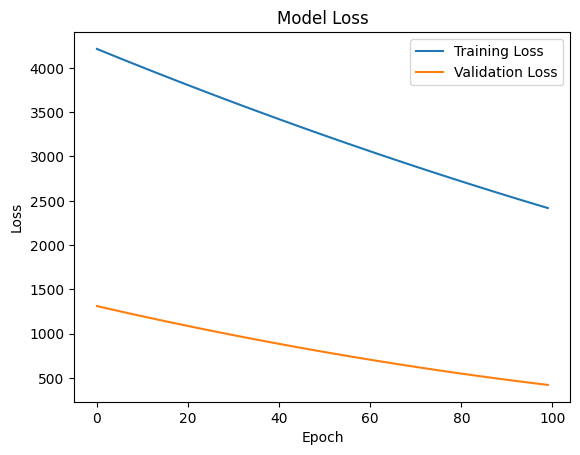

In [19]:
# COMPILE, FIT, LEARNING CURVE

model.compile(loss='mae',
              optimizer=Adam(learning_rate=0.0005), metrics=["mae"])

es = EarlyStopping(patience=10, restore_best_weights=True)

history=model.fit(X_train_scaled, y_train, epochs=100, verbose=1, batch_size= 16 ,validation_data=(X_val_scaled,y_val)
                  , callbacks=[es]
                 )

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [20]:
# EVALUATE 1

y_pred=model.predict(X_test_scaled)
mean_absolute_error(y_test,y_pred)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


18.31818447644967

In [31]:
# EVALUATE 2 baseline model:

y_hat= np.array( [ X_test[i][-1] for i in range( len(X_test) )] )
mean_absolute_error(y_test,y_hat)


7.288180610889774

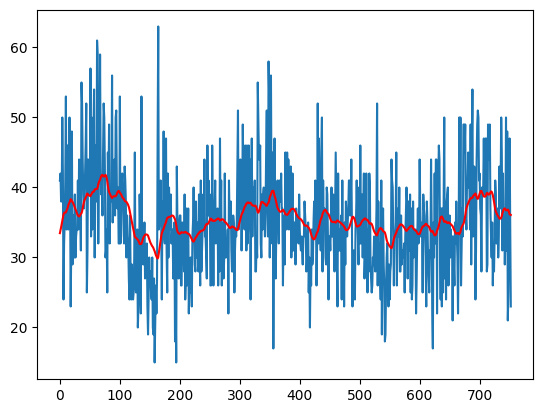

In [40]:
#plt.plot(pd.DataFrame(y_hat), color= "green")
plt.plot(pd.DataFrame(y_test))
plt.plot(pd.DataFrame(y_pred), color= "red")
plt.show()

NOW CROSS-VALIDATION (WALK FORWARD ...):

In [25]:
# Preprocess / scaling for CV:

crime_count_list = list(ca25daily_df["crime_count"])

sequence_length = 365  # number of days to consider for predicting the next day

# create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# train test val split

train_size = int(len(X) * 0.9)  # 90% for training
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

scaler=MinMaxScaler()

scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [28]:
# FUNCTIONS:
import math

def get_folds(array,n_folds):
    fold_length= math.floor( len(array) / n_folds )
    folds=[]
    for i in range(n_folds):
        folds.append( array[i*fold_length: (i+1)*fold_length] )
    return folds


def init_model():

    # RNN
    model = Sequential()

    model.add(layers.GRU(units=32, activation='relu', input_shape=(365, 1), return_sequences=True))
    model.add(layers.GRU(units=32, activation='relu', return_sequences=True))
    model.add(layers.GRU(units=16, activation='relu', return_sequences=True))
    model.add(layers.GRU(units=8, activation='relu'))

    model.add(layers.Dense(8, activation="relu")) 
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))
    
    # Compile
    model.compile(loss='mae',
              optimizer=Adam(learning_rate=0.0005), metrics=["mae"])

    return model
    

def cross_validate(X_train, y_train, n_folds):
    
    mae_list = []

    # folds
    x_folds = get_folds(X_train, n_folds)
    y_folds = get_folds(y_train, n_folds)

    for i in range(0,len(x_folds)):

        # 1 - Train/Test split the current fold
        X_train, X_test, y_train , y_test = train_test_split(
                        x_folds[i], y_folds[i] ,train_size=0.8 ,shuffle=False) 

        # 2 - Modelling
        model = init_model()
        es = EarlyStopping(patience=10, restore_best_weights=True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.2,
                            shuffle = False,
                            batch_size = 16,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        # 3 - Evaluation
        res = model.evaluate(X_test, y_test, verbose=0)    
        mae_list.append(res[1])
        print(f"Fold nr. {i+1}: MAE = {res[1]}")
    return mae_list 


In [29]:
cv5_list=cross_validate(X_train,y_train,5)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold nr. 0: MAE = 12.433998107910156
Fold nr. 1: MAE = 11.049640655517578
Fold nr. 2: MAE = 7.564866542816162
Fold nr. 3: MAE = 6.97126579284668
Fold nr. 4: MAE = 6.327563762664795


In [30]:
np.mean(cv5_list)

8.869466972351074